In [48]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

from miniAutoGrad.engine import Value
from miniAutoGrad.Neural_Network import Neuron, Layer, MLP

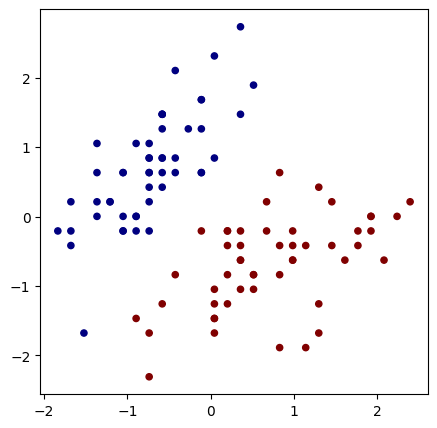

In [49]:
np.random.seed(1337)
random.seed(1337)

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Select only two classes (class 0 and class 1)
binary_class_mask = y < 2  # Filter out class 2
X = X[binary_class_mask]
y = y[binary_class_mask]

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y*2 - 1 # make y be -1 or 1

# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [50]:
# initialize a model
model = MLP(2, [16, 16, 1])
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [51]:
def load_data(batch_size=None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    return Xb, yb, [list(map(Value, xrow)) for xrow in Xb] # convert to Value object [Value(), Value(),..]

In [52]:
Xb, yb, inputs = load_data()

In [53]:
def loss():

    # forward the model to get scores
    scores = list(map(model, inputs)) # [Value(), Value(),..] but now each is output of the model

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4 
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

In [54]:
total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.9265886728337899, grad=0) 0.5


In [55]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.9265886728337899, accuracy 50.0%
step 1 loss 0.6985429232930725, accuracy 69.0%
step 2 loss 0.03682924306808606, accuracy 99.0%
step 3 loss 0.022588348430612942, accuracy 99.0%
step 4 loss 0.011985399525590605, accuracy 100.0%
step 5 loss 0.01163975557505016, accuracy 100.0%
step 6 loss 0.011635309613050416, accuracy 100.0%
step 7 loss 0.01163090722839782, accuracy 100.0%
step 8 loss 0.01162654837283166, accuracy 100.0%
step 9 loss 0.011622232998579554, accuracy 100.0%
step 10 loss 0.01161796105835667, accuracy 100.0%
step 11 loss 0.011613732505364769, accuracy 100.0%
step 12 loss 0.011609547293291419, accuracy 100.0%
step 13 loss 0.011605405376309129, accuracy 100.0%
step 14 loss 0.011601306709074498, accuracy 100.0%
step 15 loss 0.01159725124672739, accuracy 100.0%
step 16 loss 0.011593238944890156, accuracy 100.0%
step 17 loss 0.01158926975966676, accuracy 100.0%
step 18 loss 0.011585343647642047, accuracy 100.0%
step 19 loss 0.011581460565880879, accuracy 100.0%
step 

(-3.3071795918217495, 3.6928204081782505)

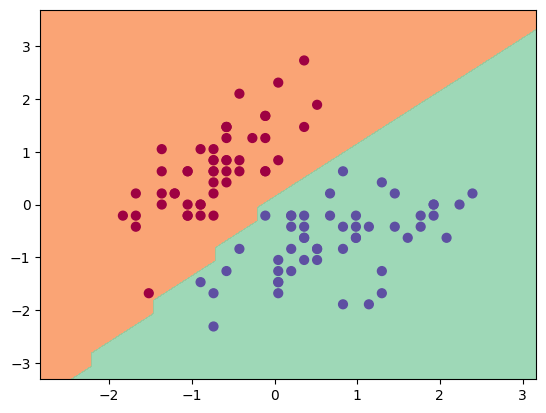

In [56]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())